# User Profiling via Clustering  


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


In [47]:
features_path = r"D:\Projects\SmartFit-SmartDiet\data\processed\pamap2_features.csv"
df = pd.read_csv(features_path)
print("Shape:", df.shape)
df.sample()

Shape: (690, 482)


,timestamp_mean,timestamp_std,timestamp_min,timestamp_max,timestamp_median,timestamp_kurtosis,timestamp_skew,timestamp_energy,timestamp_dom_freq,heart_rate_mean,...,extra_col_54_median,extra_col_54_kurtosis,extra_col_54_skew,extra_col_54_energy,extra_col_54_dom_freq,subject_id,session_type,window_start,window_end,activity
550,88.57624,15.804028,61.19,115.88,88.585,-1.197091,-0.002904,8095.517609,0.390625,89.766,...,-0.41154,0.600184,1.449036,0.238701,0.78125,108,optional,1970-01-01 00:01:01.190,1970-01-01 00:01:55.880,NaN


In [48]:
# Drop non-feature columns (subject_id, session_type, timestamps, activity label)
non_feature_cols = ['subject_id', 'session_type', 'window_start', 'window_end', 'activity']
X = df.drop(columns=non_feature_cols)

print("Features shape before scaling:", X.shape)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features shape after scaling:", X_scaled.shape)


Features shape before scaling: (690, 477)
Features shape after scaling: (690, 477)


In [49]:
print("NaNs in features before scaling:", np.isnan(X).sum())
print("NaNs in features after scaling:", np.isnan(X_scaled).sum())

NaNs in features before scaling: timestamp_mean             0
timestamp_std              0
timestamp_min              0
timestamp_max              0
timestamp_median           0
                        ... 
extra_col_54_median        0
extra_col_54_kurtosis    126
extra_col_54_skew        126
extra_col_54_energy        0
extra_col_54_dom_freq      0
Length: 477, dtype: int64
NaNs in features after scaling: 3236


In [50]:
imputer = SimpleImputer(strategy='median')  # median is robust
X_imputed = imputer.fit_transform(X)

# Then scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


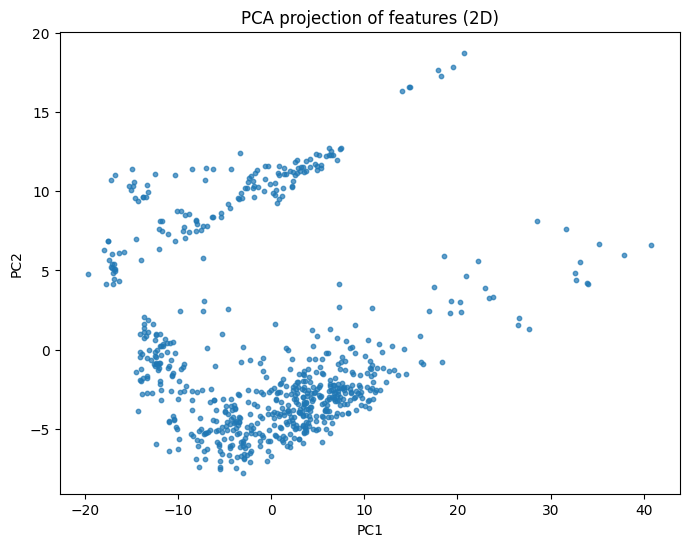

In [51]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.7)
plt.title("PCA projection of features (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


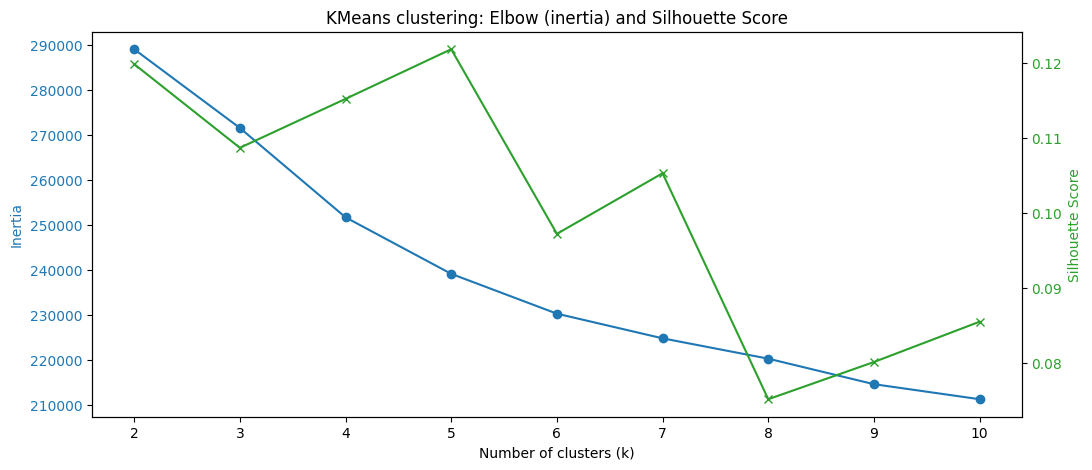

In [52]:
inertia = []
sil_scores = []
K_RANGE = range(2, 11)

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

fig, ax1 = plt.subplots(figsize=(12,5))

color = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(K_RANGE, inertia, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_RANGE, sil_scores, marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("KMeans clustering: Elbow (inertia) and Silhouette Score")
plt.show()


In [53]:
best_k = K_RANGE[np.argmax(sil_scores)]
print(f"Best k according to silhouette score: {best_k}")

kmeans_final = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

df['kmeans_cluster'] = kmeans_labels


Best k according to silhouette score: 5


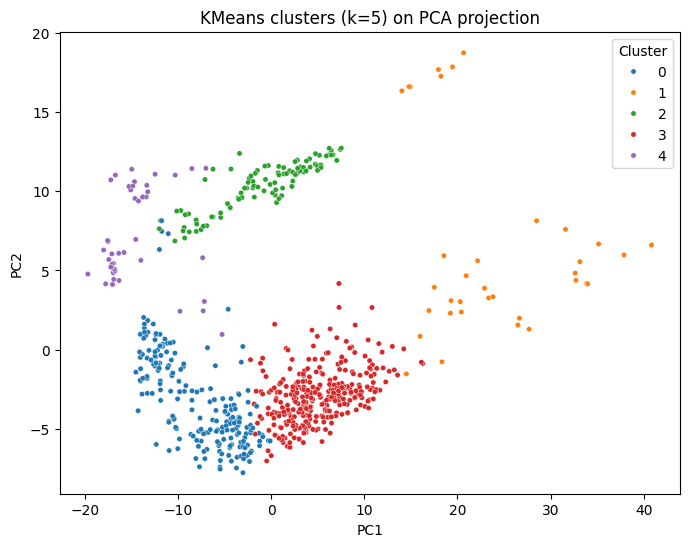

In [54]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['kmeans_cluster'], palette='tab10', legend='full', s=15)
plt.title(f"KMeans clusters (k={best_k}) on PCA projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()


In [55]:
n_components_range = range(2, 11)
cov_types = ['full', 'tied', 'diag', 'spherical']

lowest_bic = np.inf
bic_list = []
best_gmm = None

for cov_type in cov_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
        gmm.fit(X_scaled)
        bic = gmm.bic(X_scaled)
        bic_list.append((bic, cov_type, n_components))
        if bic < lowest_bic:
            lowest_bic = bic
            best_gmm = gmm

print(f"Best GMM model: covariance_type={best_gmm.covariance_type}, components={best_gmm.n_components}, BIC={lowest_bic:.2f}")


Best GMM model: covariance_type=diag, components=10, BIC=429513.55


In [56]:
gmm_labels = best_gmm.predict(X_scaled)
df['gmm_cluster'] = gmm_labels


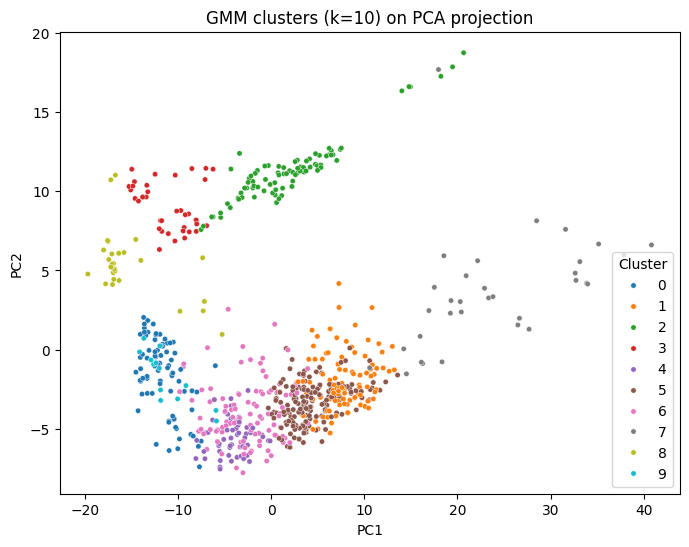

In [57]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['gmm_cluster'], palette='tab10', legend='full', s=15)
plt.title(f"GMM clusters (k={best_gmm.n_components}) on PCA projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()


Top features varying across clusters:
Index(['timestamp_energy', 'heart_rate_energy', 'extra_col_48_energy',
       'timestamp_max', 'timestamp_mean', 'timestamp_median', 'timestamp_min',
       'ankle_acc_16g_z_energy', 'hand_mag_y_energy', 'hand_temp_energy'],
      dtype='object')


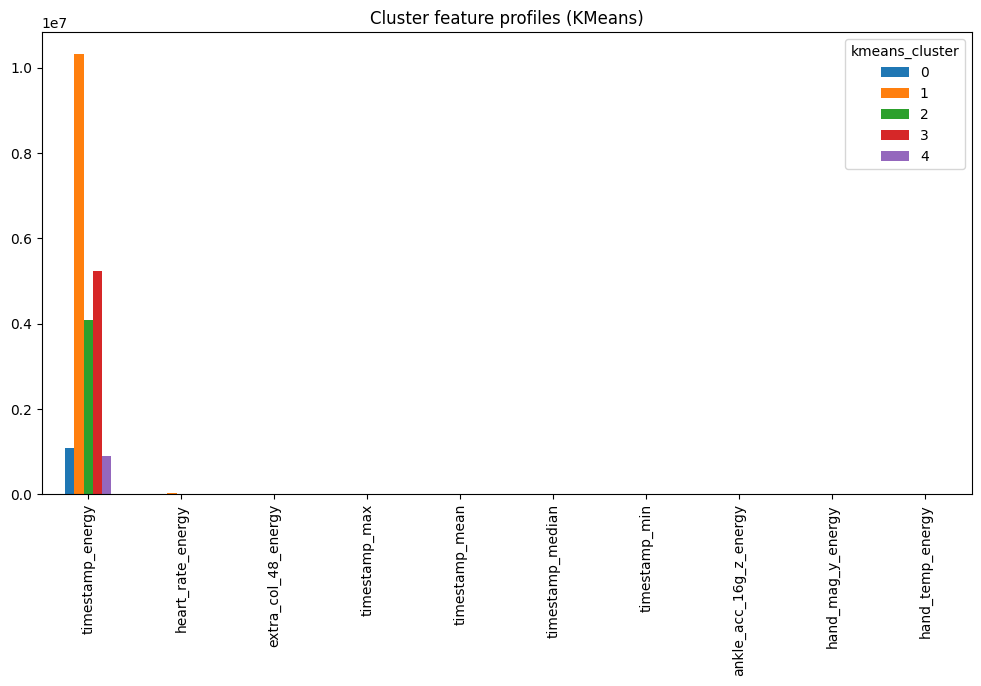

In [58]:
# Aggregate mean feature values per cluster for KMeans
cluster_profiles = df.groupby('kmeans_cluster')[X.columns].mean()

# Display top features that vary the most across clusters
top_var_features = cluster_profiles.var().sort_values(ascending=False).head(10).index
print("Top features varying across clusters:")
print(top_var_features)

cluster_profiles[top_var_features].T.plot(kind='bar', figsize=(12,6), title="Cluster feature profiles (KMeans)")
plt.show()


In [59]:
# KMeans metrics
kmeans_labels = df['kmeans_cluster']
print("KMeans Silhouette:", silhouette_score(X_scaled, kmeans_labels))
print("KMeans Calinski-Harabasz:", calinski_harabasz_score(X_scaled, kmeans_labels))
print("KMeans Davies-Bouldin:", davies_bouldin_score(X_scaled, kmeans_labels))

# GMM metrics (convert soft labels to hard)
gmm_labels = df['gmm_cluster']
print("GMM Silhouette:", silhouette_score(X_scaled, gmm_labels))
print("GMM Calinski-Harabasz:", calinski_harabasz_score(X_scaled, gmm_labels))
print("GMM Davies-Bouldin:", davies_bouldin_score(X_scaled, gmm_labels))


KMeans Silhouette: 0.12181785703837134
KMeans Calinski-Harabasz: 64.016023233977
KMeans Davies-Bouldin: 2.1873512802974098
GMM Silhouette: 0.07302417114821422
GMM Calinski-Harabasz: 40.663496403326896
GMM Davies-Bouldin: 2.6108418304119727


In [60]:
clustered_path = Path("D:\Projects\SmartFit-SmartDiet\data\processed\pamap2_features_clustered.csv")
df.to_csv(clustered_path, index=False)
print(f"Saved clustered data to {clustered_path}")


Saved clustered data to D:\Projects\SmartFit-SmartDiet\data\processed\pamap2_features_clustered.csv
